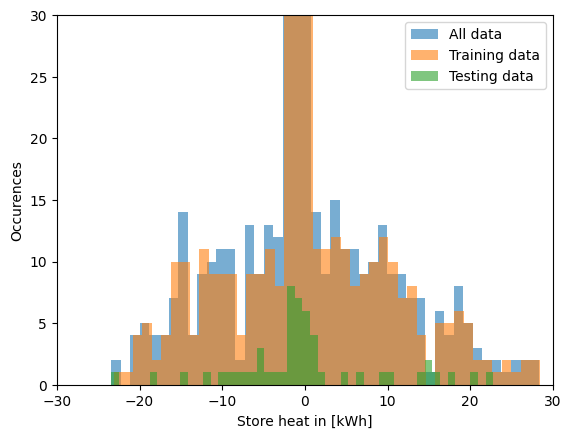

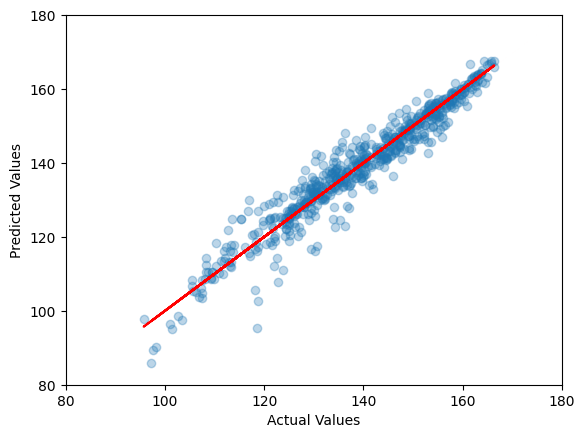

RMSE: 4.0
R-squared: 0.9
Cross-Validation RMSE: 3.6


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv('maple_storage_data.csv')
X = df[[c for c in df.columns if 'initial' in c or 'store_heat_in' in c]]
y = df[[c for c in df.columns if 'final' in c]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

plt.hist(df['store_heat_in'], bins=50, label="All data", alpha=0.6)
plt.hist(X_train['store_heat_in'], bins=50, label="Training data", alpha=0.6)
plt.hist(X_test['store_heat_in'], bins=50, label="Testing data", alpha=0.6)
plt.xlabel("Store heat in [kWh]")
plt.ylabel("Occurences")
plt.xlim([-30,30])
plt.ylim([0,30])
plt.legend()
plt.show()

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([80,180])
plt.ylim([80,180])
plt.show()

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_cv_score = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"RMSE: {round(np.sqrt(abs(mse_ridge)),1)}")
print(f"R-squared: {round(r2_ridge,1)}")
print(f"Cross-Validation RMSE: {round(np.sqrt(abs(ridge_cv_score.mean())),1)}")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

class TankStatePlotter():
    def __init__(self, initial, final, predicted, store_heat_in):
        self.initial = initial
        self.final = final
        self.predicted = predicted
        self.title = f"To storage: {store_heat_in} kWh"
        self.plot()

    def plot(self):
        overall_min = min(min(self.initial), min(self.final), min(self.predicted))
        overall_max = max(max(self.initial), max(self.final), max(self.predicted))
        norm = Normalize(vmin=overall_min, vmax=overall_max)
        cmap = matplotlib.colormaps['Reds'] 

        for i in range(12):
            layer_color = cmap(norm(self.initial[i]))
            plt.bar([0], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(0, 11-i+0.5, f'{self.initial[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.final[i]))
            plt.bar([1], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(1, 11-i+0.5, f'{self.final[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.predicted[i]))
            plt.bar([2], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(2, 11-i+0.5, f'{self.predicted[i]}', ha='center', va='center', color='black', alpha=0.5)

        plt.xticks([0,1,2], ['Before', 'After', 'Predicted After'])
        plt.yticks([])
        plt.title(self.title, fontsize=12)
        plt.show()

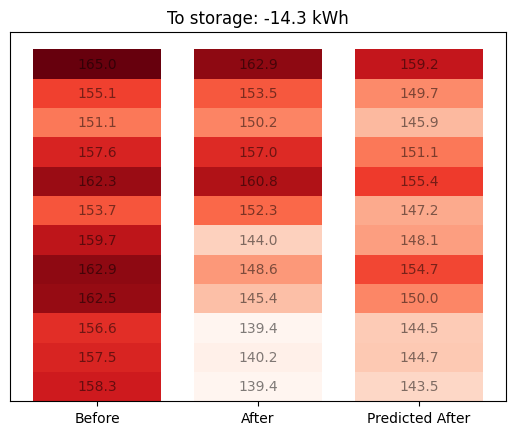

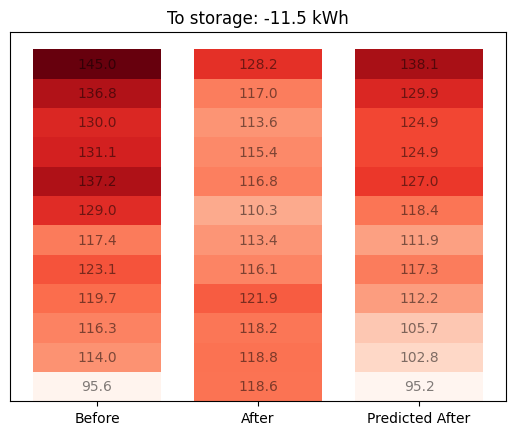

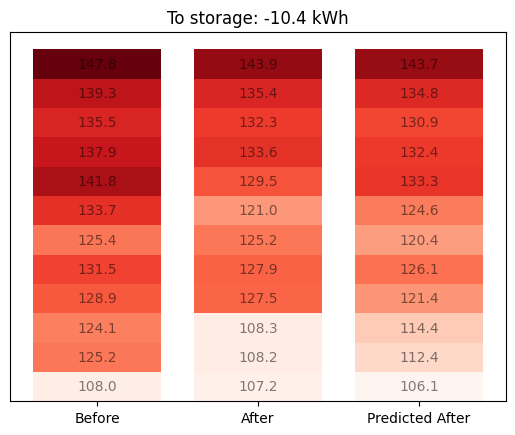

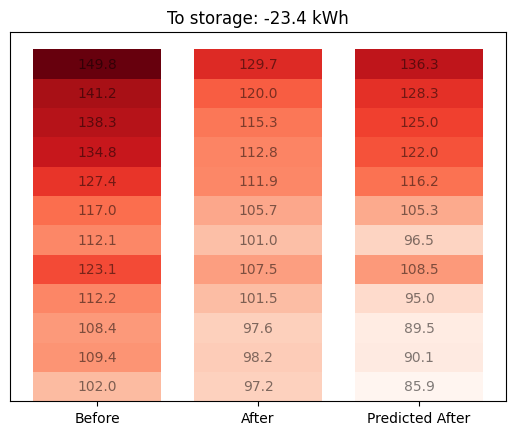

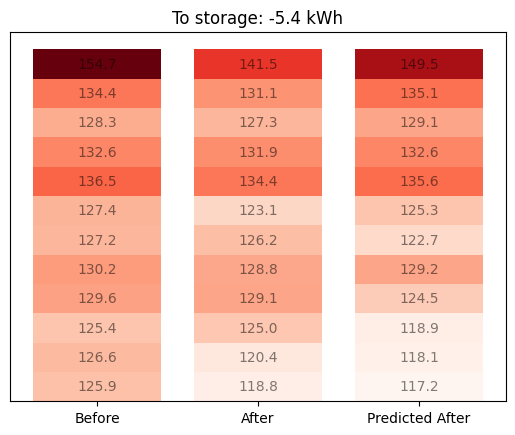

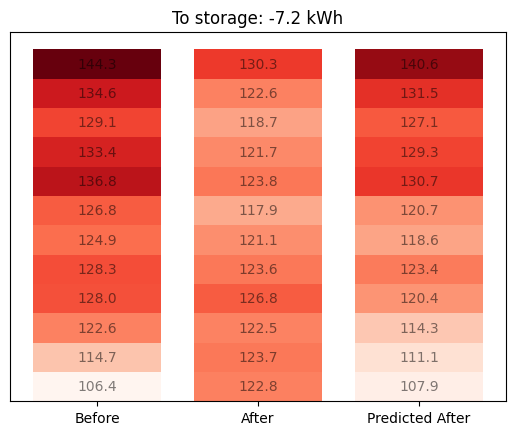

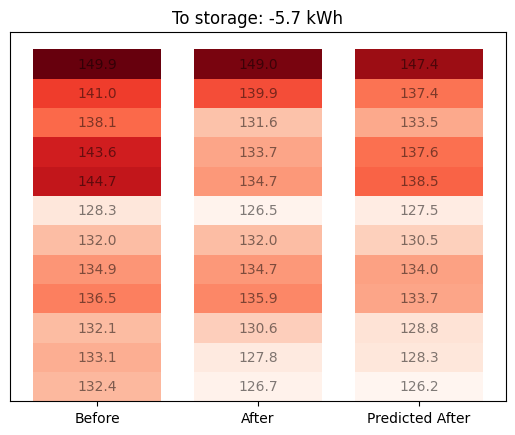

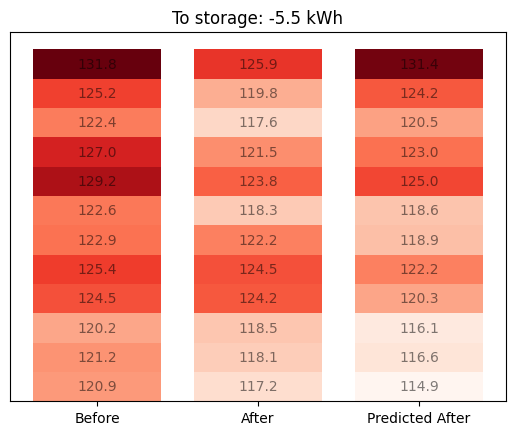

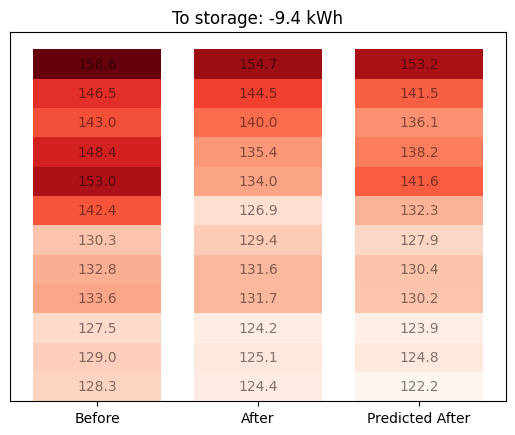

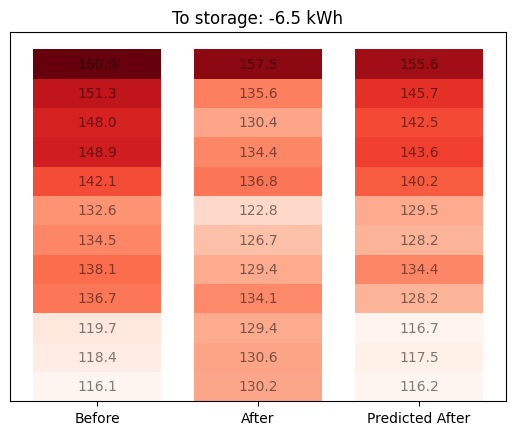

In [136]:
for i in range(50):
    print('')
    store_heat_in = X_test.iloc[i].tolist()[0]
    if store_heat_in > -5:
        continue
    initial_temp = X_test.iloc[i].tolist()[1:]
    final_temp = y_test.iloc[i].tolist()
    final_temp_pred = [round(float(x),1) for x in list(y_pred_ridge[i])]
    t = TankStatePlotter(initial_temp, final_temp, final_temp_pred, store_heat_in)